In [ ]:
# Суть проекта - отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике,
# чтобы на ранней стадии выявлять студентов, находящихся в группе риска.
# Цель развездывательного анализа данных - проверить качество данных и очистить их, если это необходимо, выделить наиболее
# значимые из них, сформулировать предположения и гипотезы для дальнейшего построения модели.

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud_math = pd.read_csv('stud_math.csv')

display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [104]:
# введём дополнительные функции

# функция определения нижнего значения, за которым находятся выбросы
def l_value(column):
    return stud_math[column].quantile(0.25) - 1.5*(stud_math[column].quantile(0.75) - stud_math[column].quantile(0.25))


# функция определения верхнего значения, за которым находятся выбросы
def h_value(column):
    return stud_math[column].quantile(0.75) + 1.5*(stud_math[column].quantile(0.75) - stud_math[column].quantile(0.25))


# функция оценки номинативных признаков с помощью теста Стьюдента
def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [69]:
# school
# всего строк - 395, значений school - 395: пропущенных значений нет

pd.DataFrame(stud_math.school.value_counts())

,school
GP,349
MS,46


In [70]:
# sex
# всего строк - 395, значений sex - 395: пропущенных значений нет

pd.DataFrame(stud_math.sex.value_counts())

,sex
F,208
M,187


,age
16,104
17,98
15,82
18,82
19,24
20,3
21,1
22,1


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

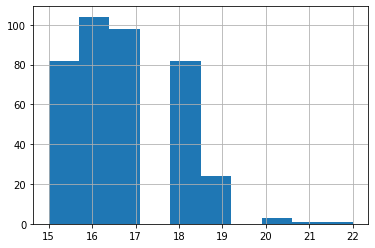

In [71]:
# age
# всего строк - 395, значений age - 395: пропущенных значений нет

display(pd.DataFrame(stud_math.age.value_counts()))
stud_math.age.hist()
stud_math.age.describe()

In [72]:
# address (U - городской, R - за городом)
# всего строк - 395, значений address - 378: 17 значений, где адрес неизвестен

stud_math.address = stud_math.address.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.address.value_counts()))
stud_math.loc[:, ['address']].info()

,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [73]:
# famsize (LE3 - не более 3, GT3 - более 3)
# всего строк - 395, значений famsize - 368: 27 значений, где размер семьи неизвестен

stud_math.famsize = stud_math.famsize.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.famsize.value_counts()))
stud_math.loc[:, ['famsize']].info()

,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [74]:
# Pstatus (T - живут вместе, A - раздельно)
# всего строк - 395, значений Pstatus - 350: 45 значений, где статус совместного жилья родителей неизвестен

stud_math.Pstatus = stud_math.Pstatus.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.Pstatus.value_counts()))
stud_math.loc[:, ['Pstatus']].info()

,Pstatus
T,314
A,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pstatus  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

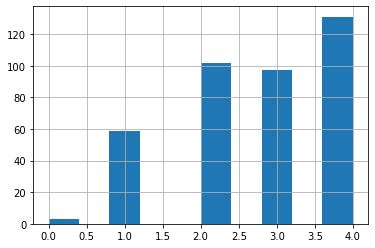

In [75]:
# Medu (4 - высшее, 3 - среднее специальное или 11 классов, 2 - 5-9 классы, 1 - 1-4 класса, 0 - нет)
# всего строк - 395, значений Medu - 392: 3 значения, где образование матери неизвестно

stud_math.Medu.hist()
stud_math.Medu.describe()

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

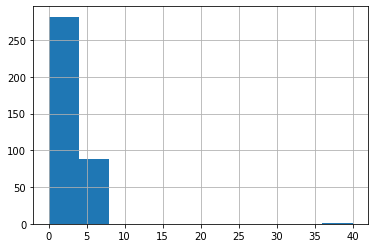

In [76]:
# Fedu (4 - высшее, 3 - среднее специальное или 11 классов, 2 - 5-9 классы, 1 - 1-4 класса, 0 - нет)
# всего строк - 395, значений Fedu - 371: 24 значения, где образование отца неизвестно

stud_math.Fedu.hist()
stud_math.Fedu.describe()

count    370.000000
mean       2.513514
std        1.087540
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

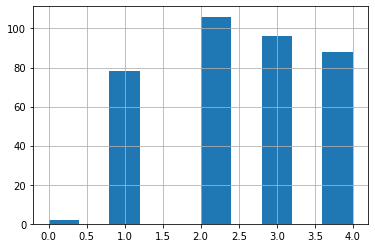

In [77]:
# отфильтруем данные от выбросов

stud_math = stud_math.loc[stud_math.Fedu <= 4]
stud_math.Fedu.hist()
stud_math.Fedu.describe()

In [78]:
# Mjob
# всего строк - 370, значений Mjob - 351: 19 значений, где работа матери неизвестна

stud_math.Mjob = stud_math.Mjob.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.Mjob.value_counts()))
stud_math.loc[:, ['Mjob']].info()

,Mjob
other,125
services,90
at_home,57
teacher,48
health,31


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Mjob    351 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [79]:
# Fjob
# всего строк - 370, значений Fjob - 336: 34 значения, где работа отца неизвестна

stud_math.Fjob = stud_math.Fjob.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.Fjob.value_counts()))
stud_math.loc[:, ['Fjob']].info()

,Fjob
other,189
services,94
teacher,26
at_home,14
health,13


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Fjob    336 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [80]:
# reason
# всего строк - 370, значений reason - 354: 16 значений, где причина выбора школы неизвестна

stud_math.reason = stud_math.reason.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.reason.value_counts()))
stud_math.loc[:, ['reason']].info()

,reason
course,128
reputation,98
home,96
other,32


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  354 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [81]:
# guardian
# всего строк - 370, значений guardian - 340: 30 значений, где опекун неизвестен

stud_math.guardian = stud_math.guardian.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.guardian.value_counts()))
stud_math.loc[:, ['guardian']].info()

,guardian
mother,236
father,78
other,26


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  340 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


count    345.000000
mean       1.449275
std        0.701664
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

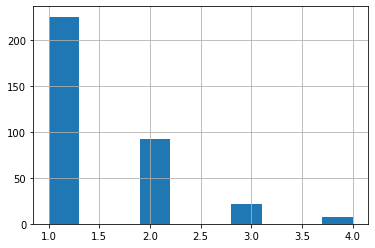

In [82]:
# traveltime (1 - <15 мин, 2 - 15-30 мин, 3 - 30-60 мин, 4 - >60 мин)
# всего строк - 370, значений traveltime - 345: 25 значений, где время в пути до школы неизвестно

stud_math.traveltime.hist()
stud_math.traveltime.describe()

count    363.000000
mean       2.027548
std        0.840489
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

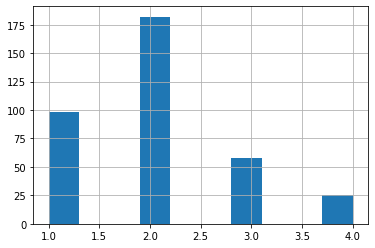

In [83]:
# studytime (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
# всего строк - 370, значений studytime - 363: 7 значений, где время на учёбу помимо школы в неделю неизвестно

stud_math.studytime.hist()
stud_math.studytime.describe()

count    351.000000
mean       0.336182
std        0.748962
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

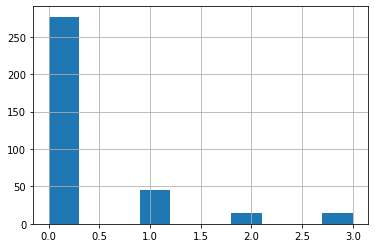

In [84]:
# failures
# всего строк - 370, значений failures - 351: 19 значений, где количество внеучебных неудач неизвестно

stud_math.failures.hist()
stud_math.failures.describe()

In [85]:
# schoolsup
# всего строк - 370, значений schoolsup - 361: 9 значений, где дополнительная образовательная поддержка неизвестна

stud_math.schoolsup = stud_math.schoolsup.apply(
    lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.schoolsup.value_counts()))
stud_math.loc[:, ['schoolsup']].info()

,schoolsup
no,314
yes,47


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  361 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [86]:
# famsup
# всего строк - 370, значений famsup - 335: 35 значений, где семейная образовательная поддержка неизвестна

stud_math.famsup = stud_math.famsup.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.famsup.value_counts()))
stud_math.loc[:, ['famsup']].info()

,famsup
yes,204
no,131


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  335 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [87]:
# paid
# всего строк - 370, значений paid - 333: 37 значений, где дополнительные платные занятия по математике неизвестны

stud_math.paid = stud_math.paid.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.paid.value_counts()))
stud_math.loc[:, ['paid']].info()

,paid
no,188
yes,145


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    333 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [88]:
# activities
# всего строк - 370, значений activities - 356: 14 значений, где дополнительные внеучебные занятия неизвестны

stud_math.activities = stud_math.activities.apply(lambda x: None if x=='' else x)
display(pd.DataFrame(stud_math.activities.value_counts()))
stud_math.loc[:, ['activities']].info()

,activities
yes,180
no,176


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  356 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [89]:
# nursery
# всего строк - 370, значений nursery - 354: 16 значений, где посещение детского сада неизвестно

stud_math.nursery = stud_math.nursery.apply(lambda x: None if x=='' else x)
display(pd.DataFrame(stud_math.nursery.value_counts()))
stud_math.loc[:, ['nursery']].info()

,nursery
yes,279
no,75


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  354 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


count    363.000000
mean      -6.082645
std        2.521466
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

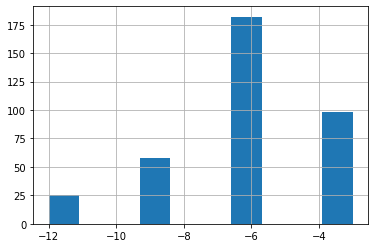

In [90]:
# studytime, granular
# всего строк - 370, значений studytime, granular - 363: 7 значений неизвестно

stud_math['studytime, granular'].hist()
stud_math['studytime, granular'].describe()

In [91]:
# higher
# всего строк - 370, значений higher - 352: 18 значений, где желание получить высшее образование неизвестно

stud_math.higher = stud_math.higher.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.higher.value_counts()))
stud_math.loc[:, ['higher']].info()

,higher
yes,333
no,19


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  352 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [92]:
# internet
# всего строк - 370, значений internet - 337: 33 значения, где наличие интернета дома неизвестно

stud_math.internet = stud_math.internet.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.internet.value_counts()))
stud_math.loc[:, ['internet']].info()

,internet
yes,283
no,54


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  337 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [93]:
# romantic
# всего строк - 370, значений romantic - 342: 28 значений, где наличие романтических отношений неизвестно

stud_math.romantic = stud_math.romantic.apply(lambda x: None if x == '' else x)
display(pd.DataFrame(stud_math.romantic.value_counts()))
stud_math.loc[:, ['romantic']].info()

,romantic
no,226
yes,116


<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  342 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


count    346.000000
mean       3.936416
std        0.939629
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

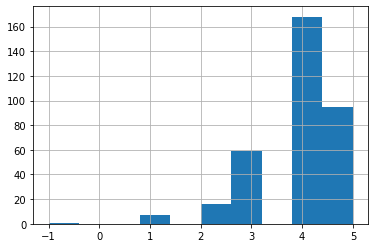

In [94]:
# famrel
# всего строк - 370, значений famrel - 346: 24 значения, где семейные отношения неизвестны

stud_math.famrel.hist()
stud_math.famrel.describe()

count    345.000000
mean       3.950725
std        0.902455
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

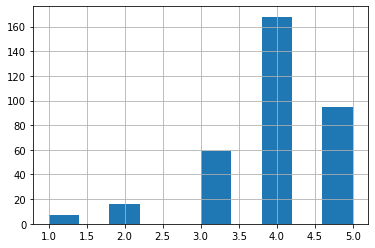

In [95]:
# отфильтруем данные от выбросов

stud_math = stud_math.loc[stud_math.famrel >= 1]
stud_math.famrel.hist()
stud_math.famrel.describe()

count    336.000000
mean       3.229167
std        1.003508
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

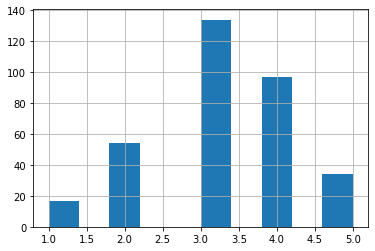

In [96]:
# freetime
# всего строк - 345, значений freetime - 336: 9 значений, где свободное время после школы неизвестно

stud_math.freetime.hist()
stud_math.freetime.describe()

count    337.000000
mean       3.106825
std        1.104852
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

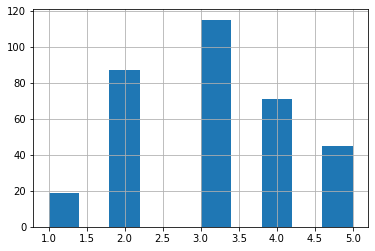

In [97]:
# goout
# всего строк - 345, значений goout - 337: 8 значений, где проведение времени с друзьями неизвестно

stud_math.goout.hist()
stud_math.goout.describe()

count    332.000000
mean       3.469880
std        1.386925
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

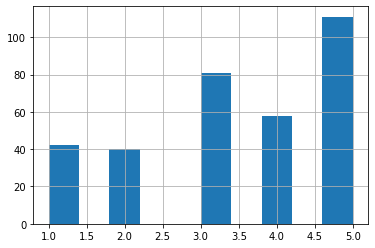

In [98]:
# health
# всего строк - 345, значений goout - 332: 13 значений, где проведение времени с друзьями неизвестно

stud_math.health.hist()
stud_math.health.describe()

count    333.000000
mean       7.315315
std       24.755302
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

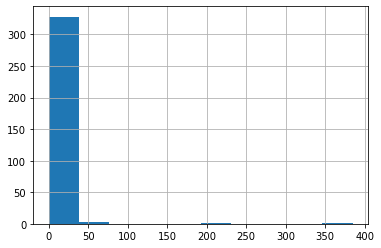

In [99]:
# absences
# всего строк - 345, значений absences - 333: 12 значений, где количество пропущенных занятий неизвестно

stud_math.absences.hist()
stud_math.absences.describe()

count    331.000000
mean       5.555891
std        7.363241
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       56.000000
Name: absences, dtype: float64

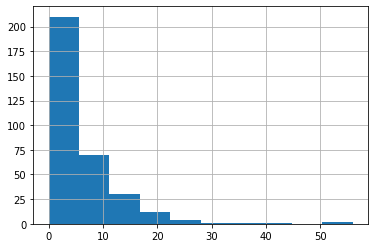

In [100]:
# отфильтруем данные от выбросов

stud_math = stud_math.loc[stud_math.absences <= 100]
stud_math.absences.hist()
stud_math.absences.describe()

count    326.000000
mean      52.147239
std       22.401712
min        0.000000
25%       41.250000
50%       55.000000
75%       65.000000
max      100.000000
Name: score, dtype: float64

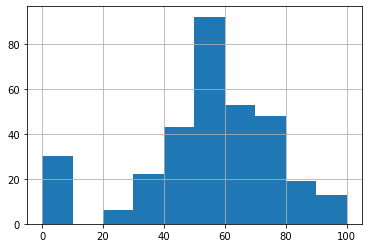

In [101]:
# score
# всего строк - 331, значений score - 326: 5 значений, где баллы по математике неизвестны

stud_math.score.hist()
stud_math.score.describe()

5.625


count    331.000000
mean      52.147239
std       22.231355
min        0.000000
25%       45.000000
50%       55.000000
75%       65.000000
max      100.000000
Name: score, dtype: float64

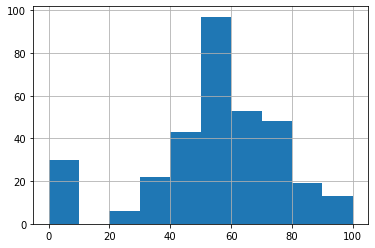

In [102]:
# проверим данные на наличие выбросов:

print(l_value('score'))
# выбросами будут являться значения, ниже 5.625.
# Т.к. это небольшой отрезок с данными, а так же для полноты анализа, будем считать что выбросов нет.


# Так как 'score' - это целевой параметр, и пропущенных значений не много, заменим их на медианные:

stud_math.score.fillna(stud_math.score.mean(), inplace=True)
stud_math.score.hist()
stud_math.score.describe()

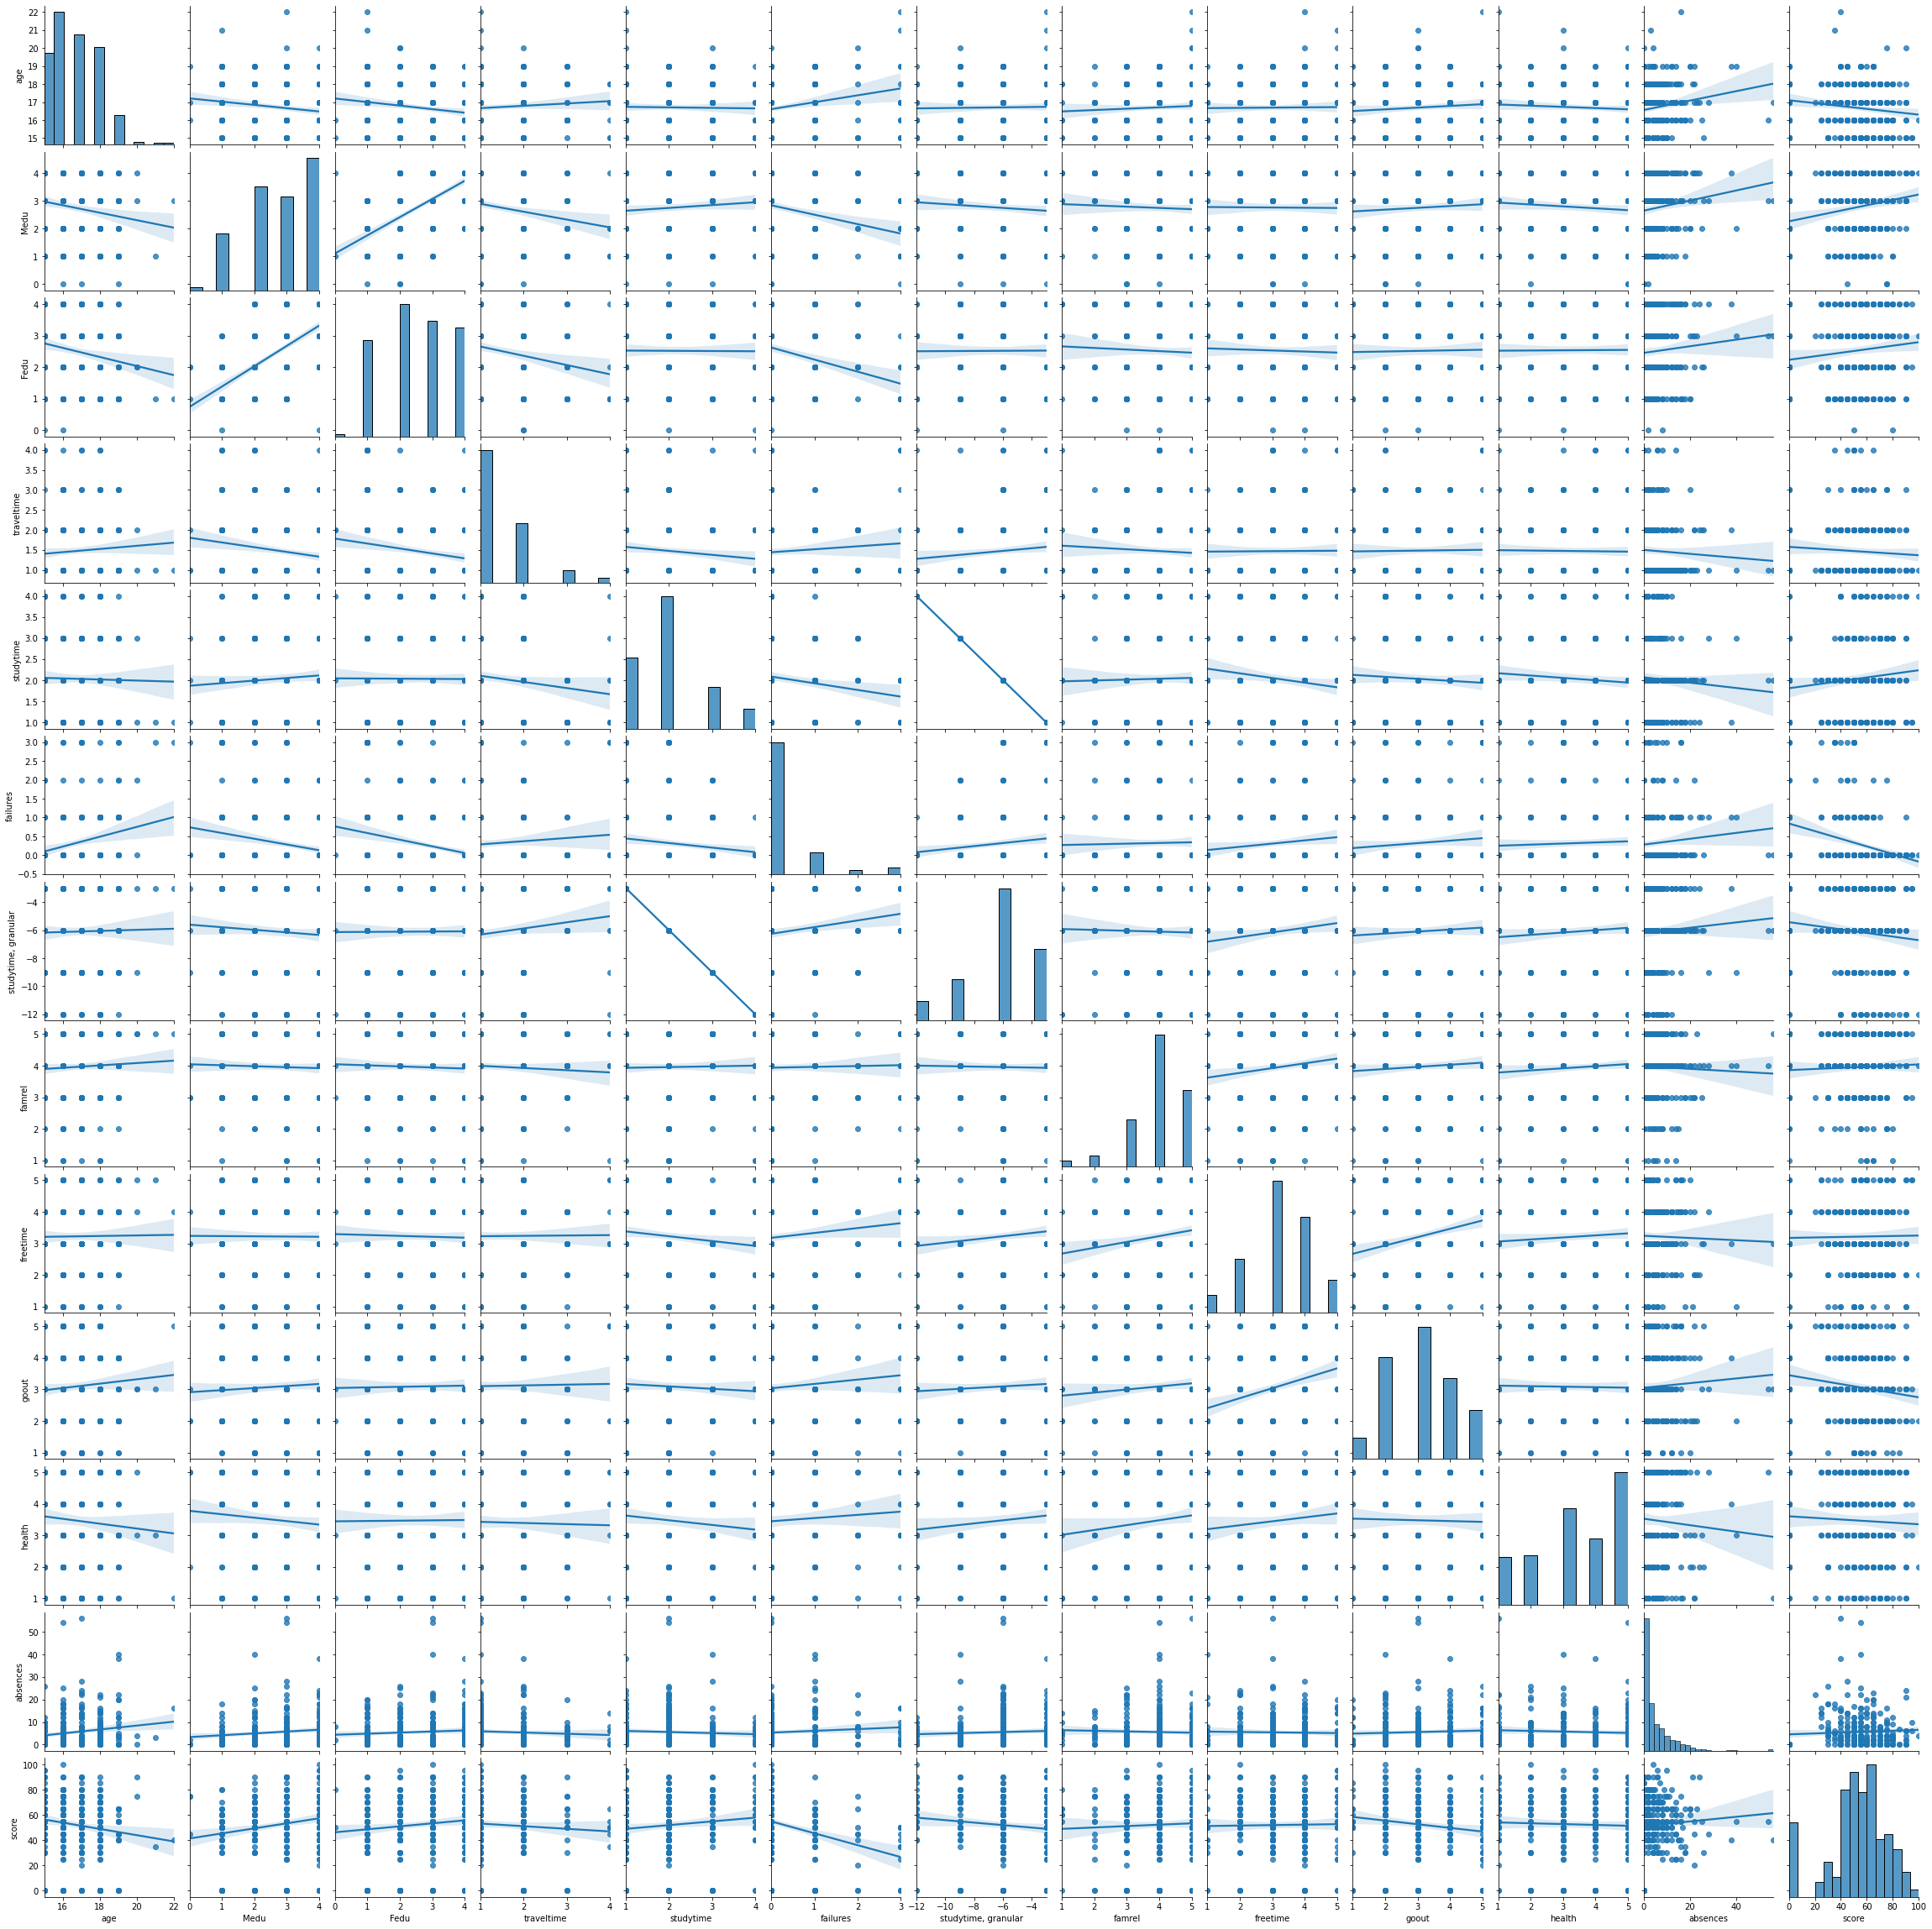

In [60]:
# для остальных параметров отсутствующие значения составляют менее 15%, поэтому их можно не заменять

sns.pairplot(stud_math, kind = 'reg')

In [111]:
stud_math.corr()
# по матрице корреляций видно, что:
# - 'studytime' и 'studytime, granular' скоррелированы противоположно - для анализа данных один из параметров можно исключить.
# Оставим 'studytime'.
# данные, которые наиболее влияют на баллы 'score' это: 'age', 'Medu', 'Fedu', 'studytime', 'failures', 'goout' 
# слабоскорреклированные с баллами по математике параметры - 'traveltime', 'famrel', 'freetime', 'health', 'absences'

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.156230,-0.168238,0.071708,-0.019213,0.223545,0.019213,0.053071,0.011246,0.081128,-0.071476,0.150496,-0.138787
Medu,-0.156230,1.000000,0.649339,-0.183575,0.079136,-0.227670,-0.079136,-0.037540,-0.007904,0.065083,-0.086337,0.122147,0.194015
Fedu,-0.168238,0.649339,1.000000,-0.190456,-0.005535,-0.259644,0.005535,-0.041272,-0.030685,0.018502,0.008007,0.070776,0.113699
traveltime,0.071708,-0.183575,-0.190456,1.000000,-0.120655,0.079594,0.120655,-0.056083,0.008059,0.015462,-0.018394,-0.052200,-0.065320
studytime,-0.019213,0.079136,-0.005535,-0.120655,1.000000,-0.138769,-1.000000,0.021930,-0.129990,-0.060053,-0.090732,-0.055309,0.112242
failures,0.223545,-0.227670,-0.259644,0.079594,-0.138769,1.000000,0.138769,0.021821,0.114783,0.094840,0.054503,0.077784,-0.301465
"studytime, granular",0.019213,-0.079136,0.005535,0.120655,-1.000000,0.138769,1.000000,-0.021930,0.129990,0.060053,0.090732,0.055309,-0.112242
famrel,0.053071,-0.037540,-0.041272,-0.056083,0.021930,0.021821,-0.021930,1.000000,0.167052,0.080827,0.101424,-0.034116,0.044158
freetime,0.011246,-0.007904,-0.030685,0.008059,-0.129990,0.114783,0.129990,0.167052,1.000000,0.288308,0.089649,-0.024020,0.016666
goout,0.081128,0.065083,0.018502,0.015462,-0.060053,0.094840,0.060053,0.080827,0.288308,1.000000,-0.020271,0.050191,-0.141832


In [112]:
# Проведём оценку статистической разницы в распределении оценок по номинативным признакам с помощью теста Стьюдента

for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
            'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
            'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher


In [115]:
# Итоги:
# таким образом, самые важные параметры, которые предлагается использовать в дальнейшем для построения модели это:
# 'address', 'paid', 'higher', 'age', 'Medu', 'Fedu', 'studytime', 'failures', 'goout'

stud_math_for_model = stud_math.loc[:, [
    'address', 'paid', 'higher', 'age', 'Medu', 'Fedu', 'studytime', 'failures', 'goout']]
stud_math_for_model.head()

,address,paid,higher,age,Medu,Fedu,studytime,failures,goout
0,U,no,yes,18,4.0,4.0,2.0,0.0,4.0
1,U,no,yes,17,1.0,1.0,2.0,0.0,3.0
2,U,NaN,yes,15,1.0,1.0,2.0,3.0,2.0
3,U,yes,yes,15,4.0,2.0,3.0,0.0,2.0
4,U,yes,yes,16,3.0,3.0,2.0,0.0,2.0


In [ ]:
# Выводы:
# 1. В данных количество пустых значений не высокое - не превышает 11%;
# 2. Выбросы найдены только в столбцах 'Fedu', 'famrel' и 'absences' - поэтому в целом данные достаточно чистые;
# 3. Положительная корреляция образования матери и отца и баллов по госэкзамену может говорить о том, что образование родителей
# напрямую влияет на успехи в образовании ребёнка;
# 4. Отрицательная корреляция возраста и баллов по госэкзамену может говорить о том, что учёба даётся хуже с возрастом;
# 5. Отрицательная корреляция количества внеучебных неудач и баллов по госэкзамену может говорить о том, что на успеваемость
# детей влияет так же и их внеучебная жизнь;
# 6. Положительная корреляция времени на учёбу помимо школы и баллов по госэкзамену может говорить о том, что дополнительные
# самостоятельные занятия положительно влияют на итоговый результат;
# 7. Отрицательная корреляция проведения времени с друзьями и баллов по госэкзамену может говорить о том, что растрата свобдного
# времени негативно сказывается на успеваемости;
# 8. Параметры 'studytime' и 'studytime, granular' скоррелированы с индексом -1, что может говорить о том, что
# 'studytime, granular' - это некое значение, напрямую зависящее от времени на учёбу помимо школы (с коэффициентом -2).

# По поводу 'studytime, granular' - честно говоря у меня нет преположений, что данный параметр значит.